# 라이브러리 호출

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font', family='nanum')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')   


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import catboost as cbt

from sklearn.model_selection import GridSearchCV

# 데이터 불러오기

In [3]:
data = pd.read_csv('./영화 관객수/movies_train.csv')

In [4]:
data.head()

title   distributor genre release_time  time screening_rat director  \
0     개들의 전쟁      롯데엔터테인먼트    액션   2012-11-22    96      청소년 관람불가      조병옥   
1       내부자들        (주)쇼박스   느와르   2015-11-19   130      청소년 관람불가      우민호   
2  은밀하게 위대하게        (주)쇼박스    액션   2013-06-05   123       15세 관람가      장철수   
3   나는 공무원이다        (주)NEW   코미디   2012-07-12   101        전체 관람가      구자홍   
4       불량남녀  쇼박스(주)미디어플렉스   코미디   2010-11-04   108       15세 관람가      신근호   

   dir_prev_bfnum  dir_prev_num  num_staff  num_actor  box_off_num  
0             NaN             0         91          2        23398  
1      1161602.50             2        387          3      7072501  
2       220775.25             4        343          4      6959083  
3        23894.00             2         20          6       217866  
4            1.00             1        251          2       483387

- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수 (target)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [6]:
print('genre  :', data['genre'].unique())
print('distributor  :', data['distributor'].unique())
print('screening_rat  :', data['screening_rat'].unique())
print('director  :', data['director'].unique())

genre  : ['액션' '느와르' '코미디' '다큐멘터리' '뮤지컬' '드라마' '멜로/로맨스' '공포' '서스펜스' '애니메이션' '미스터리'
 'SF']
distributor  : ['롯데엔터테인먼트' '(주)쇼박스' '(주)NEW' '쇼박스(주)미디어플렉스' '백두대간' '유니버설픽쳐스인터내셔널코리아'
 '(주)두타연' '(주) 케이알씨지' '(주)콘텐츠 윙' '(주)키노아이' '(주)팝 파트너스' 'CJ E&M 영화부문'
 '(주) 영화제작전원사' 'CJ E&M Pictures' 'CGV 무비꼴라쥬' '리틀빅픽처스' '스폰지' 'CJ 엔터테인먼트'
 'CGV아트하우스' '조이앤시네마' '인디플러그' '콘텐츠판다' '인디스토리' '(주)팝엔터테인먼트' '시네마서비스' '웃기씨네'
 '영화사 진진' '(주)레인보우 팩토리' '김기덕 필름' 'NEW' 'CJ CGV' '동국대학교 충무로영상제작센터'
 'BoXoo 엔터테인먼트' '(주)마운틴픽쳐스' 'CGV 아트하우스' '메가박스(주)플러스엠' '골든타이드픽처스' '파이오니아21'
 '디 씨드' '드림팩트 엔터테인먼트' '시너지' '디마엔터테인먼트' '판다미디어' '(주)스톰픽쳐스코리아'
 '(주)예지림 엔터테인먼트' '(주) 영화사조제' '보람엔터테인먼트' '(주)시네마달' '노바엔터테인먼트' '(주)패스파인더씨앤씨'
 '(주)대명문화공장' '(주)온비즈넷' 'KT&G 상상마당' '무비꼴라쥬' '인벤트 디' '씨네그루(주)키다리이엔티'
 '스튜디오후크' '시네마 달' '나이너스엔터테인먼트(주)' 'THE 픽쳐스' '영구아트무비' '리틀빅픽쳐스' '어뮤즈'
 '이모션 픽처스' '(주)이스트스카이필름' '필라멘트 픽쳐스' '조이앤컨텐츠그룹' '타임스토리그룹' '마운틴 픽처스'
 '(주)휘엔터테인먼트' '이십세기폭스코리아(주)' '(주)피터팬픽쳐스' '에스와이코마드' '(주)더픽쳐스' '오퍼스픽쳐스'
 '(주)고앤고 필름' '사람과 사람들' '(주)JK필름' '씨너스엔터테인먼트(주)' 'KT' '싸이더스FNH

## 결측치 처리

In [7]:
print(data[data['dir_prev_num'] == 0].shape)
data[data['dir_prev_num'] == 0].isna().sum()

(330, 12)


title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [8]:
data.fillna(0,inplace=True)
data.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

## 가변수화

In [9]:
data = pd.get_dummies(data,columns=['screening_rat','genre'],drop_first=True)

In [10]:
data.head()

title   distributor release_time  time director  dir_prev_bfnum  \
0     개들의 전쟁      롯데엔터테인먼트   2012-11-22    96      조병옥            0.00   
1       내부자들        (주)쇼박스   2015-11-19   130      우민호      1161602.50   
2  은밀하게 위대하게        (주)쇼박스   2013-06-05   123      장철수       220775.25   
3   나는 공무원이다        (주)NEW   2012-07-12   101      구자홍        23894.00   
4       불량남녀  쇼박스(주)미디어플렉스   2010-11-04   108      신근호            1.00   

   dir_prev_num  num_staff  num_actor  box_off_num  ...  genre_느와르  \
0             0         91          2        23398  ...          0   
1             2        387          3      7072501  ...          1   
2             4        343          4      6959083  ...          0   
3             2         20          6       217866  ...          0   
4             1        251          2       483387  ...          0   

   genre_다큐멘터리  genre_드라마  genre_멜로/로맨스  genre_뮤지컬  genre_미스터리  genre_서스펜스  \
0            0          0             0          0           0           0   
1            0          0             0          0           0           0   
2            0          0             0          0           0           0   
3            0          0             0          0           0           0   
4            0          0             0          0           0           0   

   genre_애니메이션  genre_액션  genre_코미디  
0            0         1          0  
1            0         0          0  
2            0         1          0  
3            0         0          1  
4            0         0          1  

[5 rows x 24 columns]

## Feature 정리

In [14]:
data.drop(['title','distributor','director'],axis=1,inplace=True)
data.head()

KeyError: "['title', 'distributor', 'director'] not found in axis"

In [ ]:
data['release_time'] = data['release_time'].astype('datetime64[ns]')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   release_time            600 non-null    datetime64[ns]
 1   time                    600 non-null    int64         
 2   dir_prev_bfnum          600 non-null    float64       
 3   dir_prev_num            600 non-null    int64         
 4   num_staff               600 non-null    int64         
 5   num_actor               600 non-null    int64         
 6   box_off_num             600 non-null    int64         
 7   screening_rat_15세 관람가   600 non-null    uint8         
 8   screening_rat_전체 관람가    600 non-null    uint8         
 9   screening_rat_청소년 관람불가  600 non-null    uint8         
 10  genre_공포                600 non-null    uint8         
 11  genre_느와르               600 non-null    uint8         
 12  genre_다큐멘터리             600 non-null    uint8     

# 데이터 분석

In [ ]:
import DataAnalysis_ksw as da

## 단변량 분석

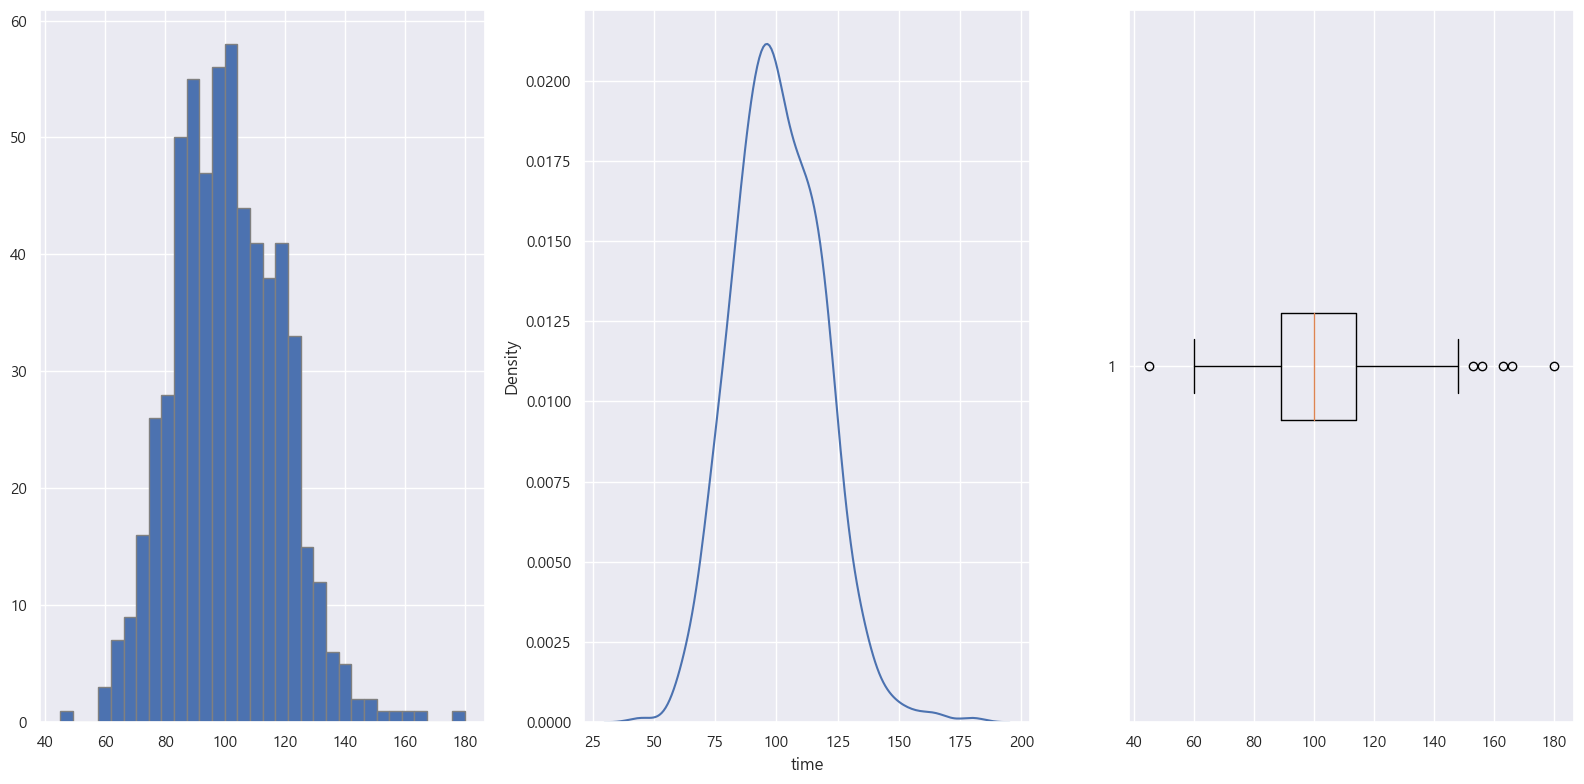

smaller :  [89. 60.]
bigger :  [114. 148.]
count    600.000000
mean     100.863333
std       18.097528
min       45.000000
25%       89.000000
50%      100.000000
75%      114.000000
max      180.000000
Name: time, dtype: float64


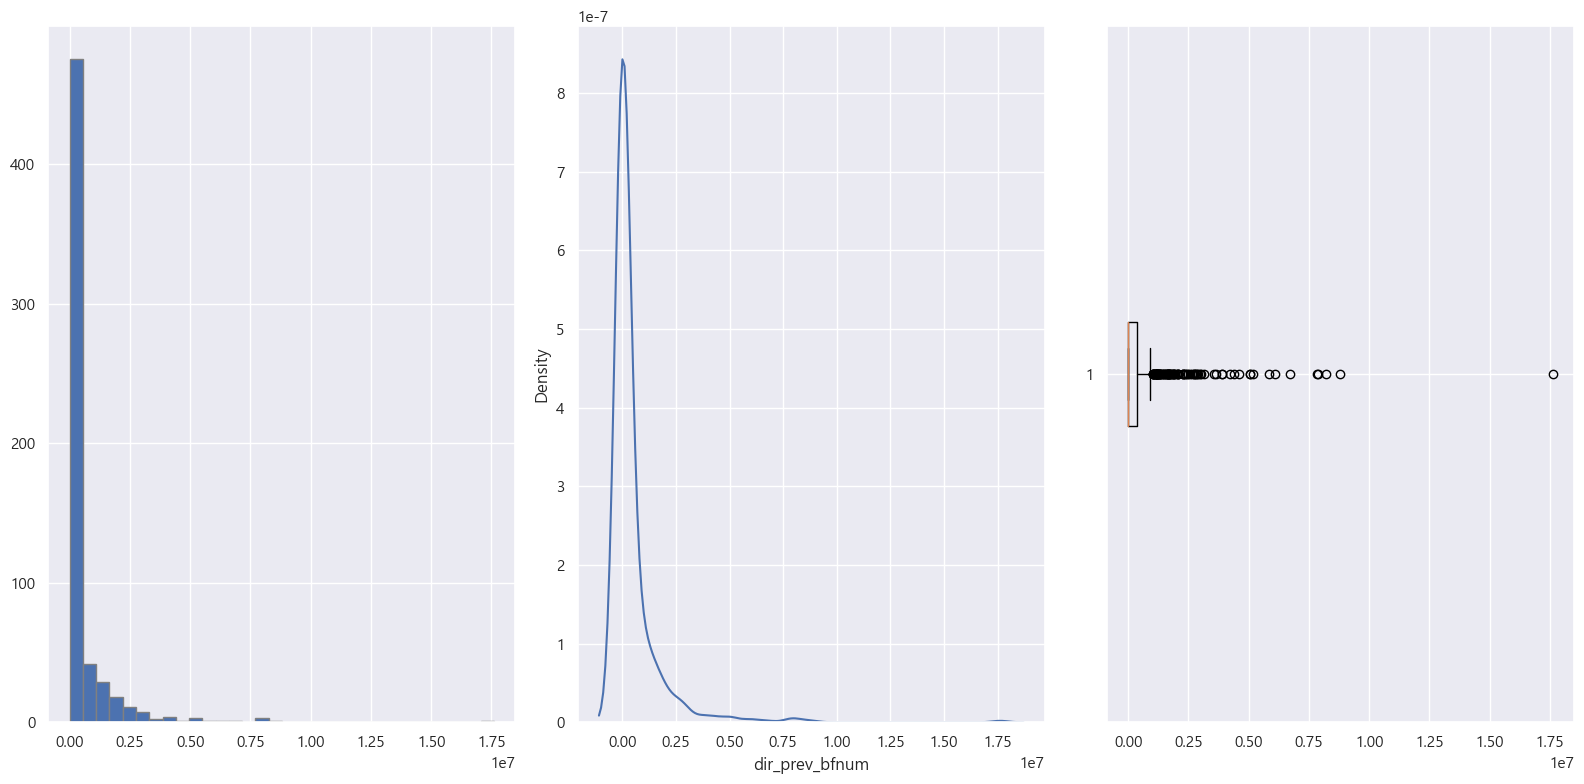

smaller :  [0. 0.]
bigger :  [376141.625 922680.   ]
count    6.000000e+02
mean     4.726993e+05
std      1.309474e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.761416e+05
max      1.761531e+07
Name: dir_prev_bfnum, dtype: float64


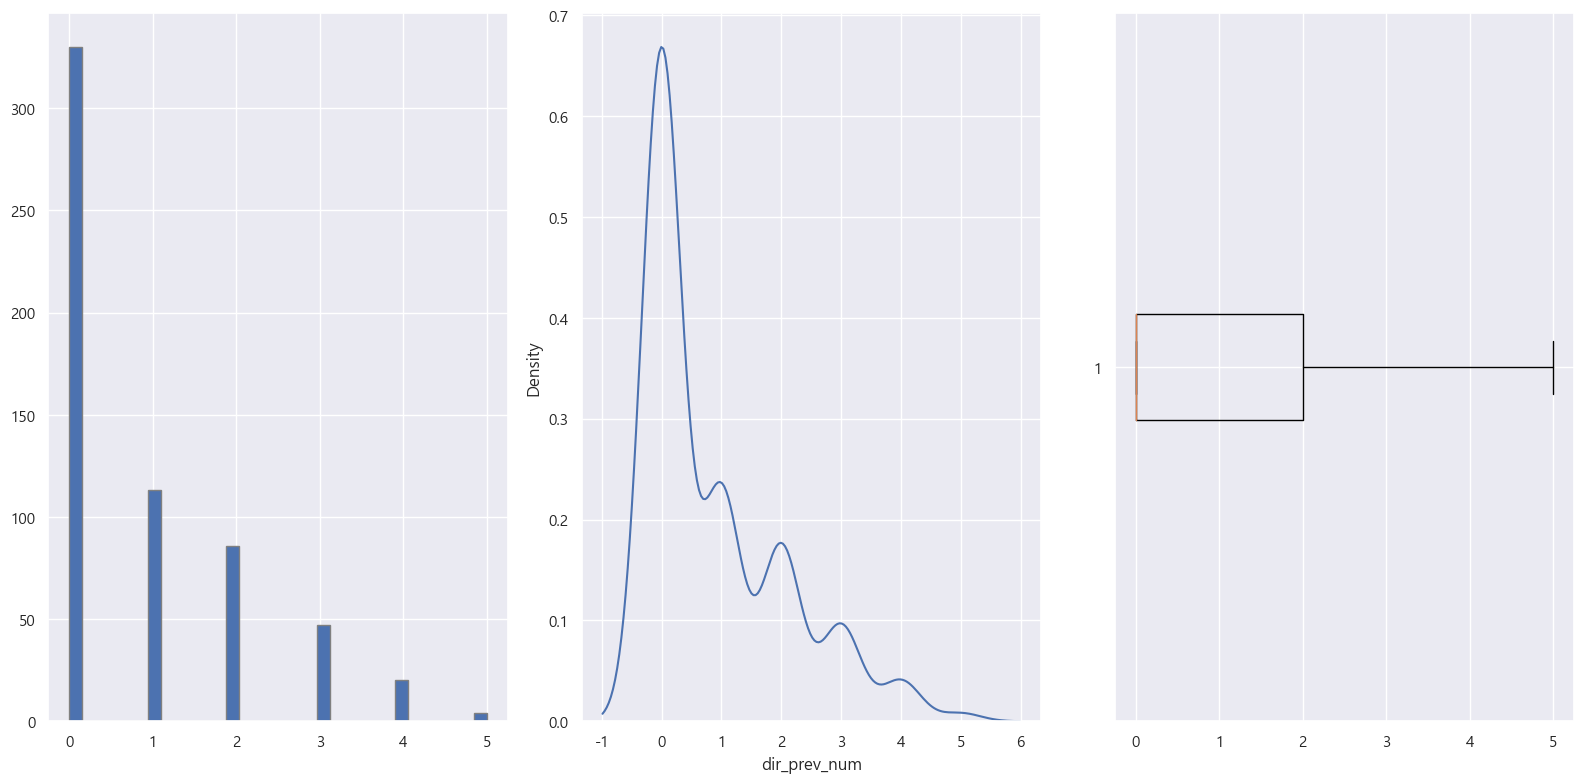

smaller :  [0. 0.]
bigger :  [2. 5.]
count    600.000000
mean       0.876667
std        1.183409
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        5.000000
Name: dir_prev_num, dtype: float64


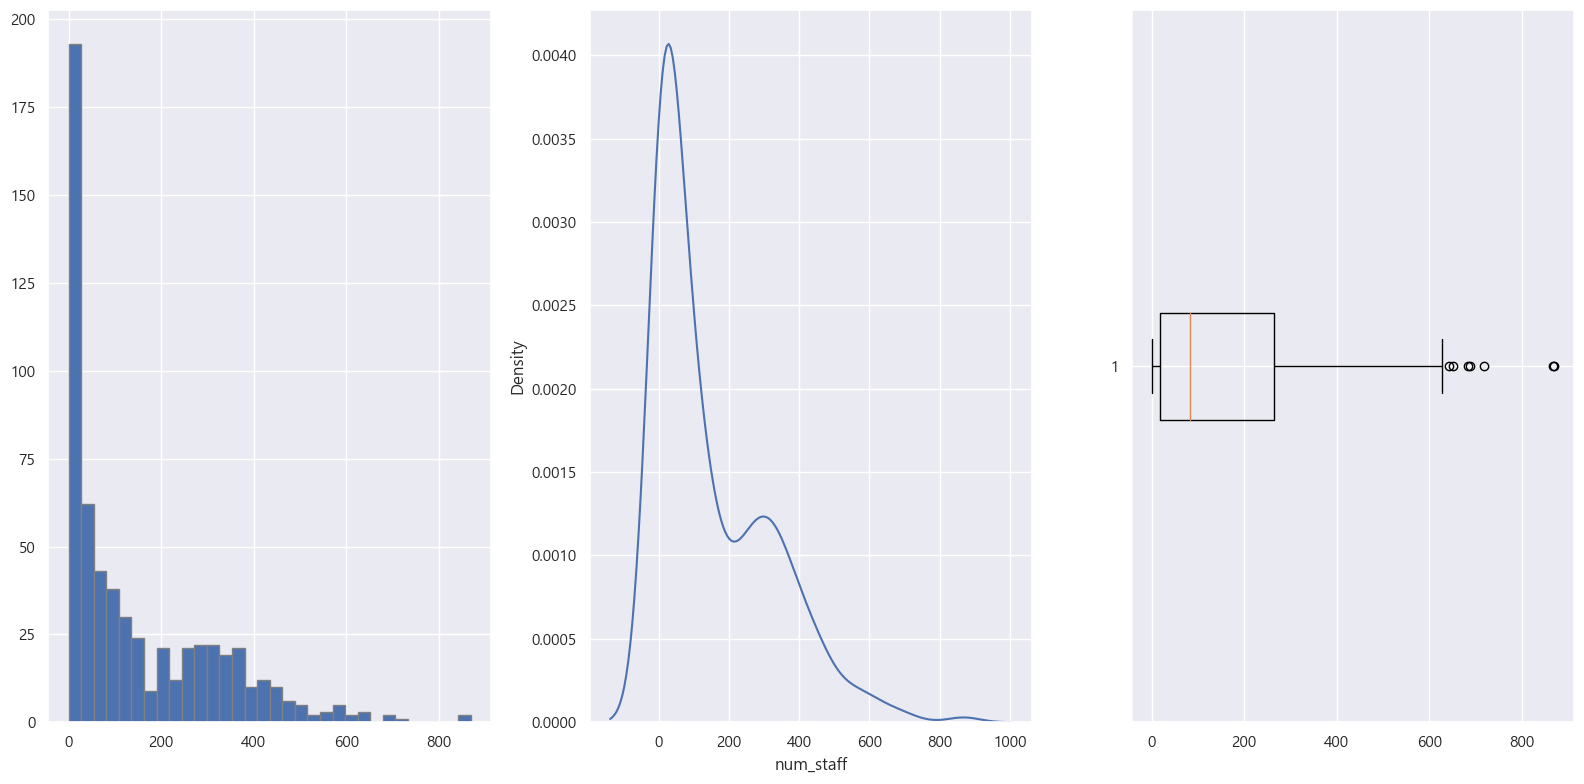

smaller :  [17.  0.]
bigger :  [264. 628.]
count    600.000000
mean     151.118333
std      165.654671
min        0.000000
25%       17.000000
50%       82.500000
75%      264.000000
max      869.000000
Name: num_staff, dtype: float64


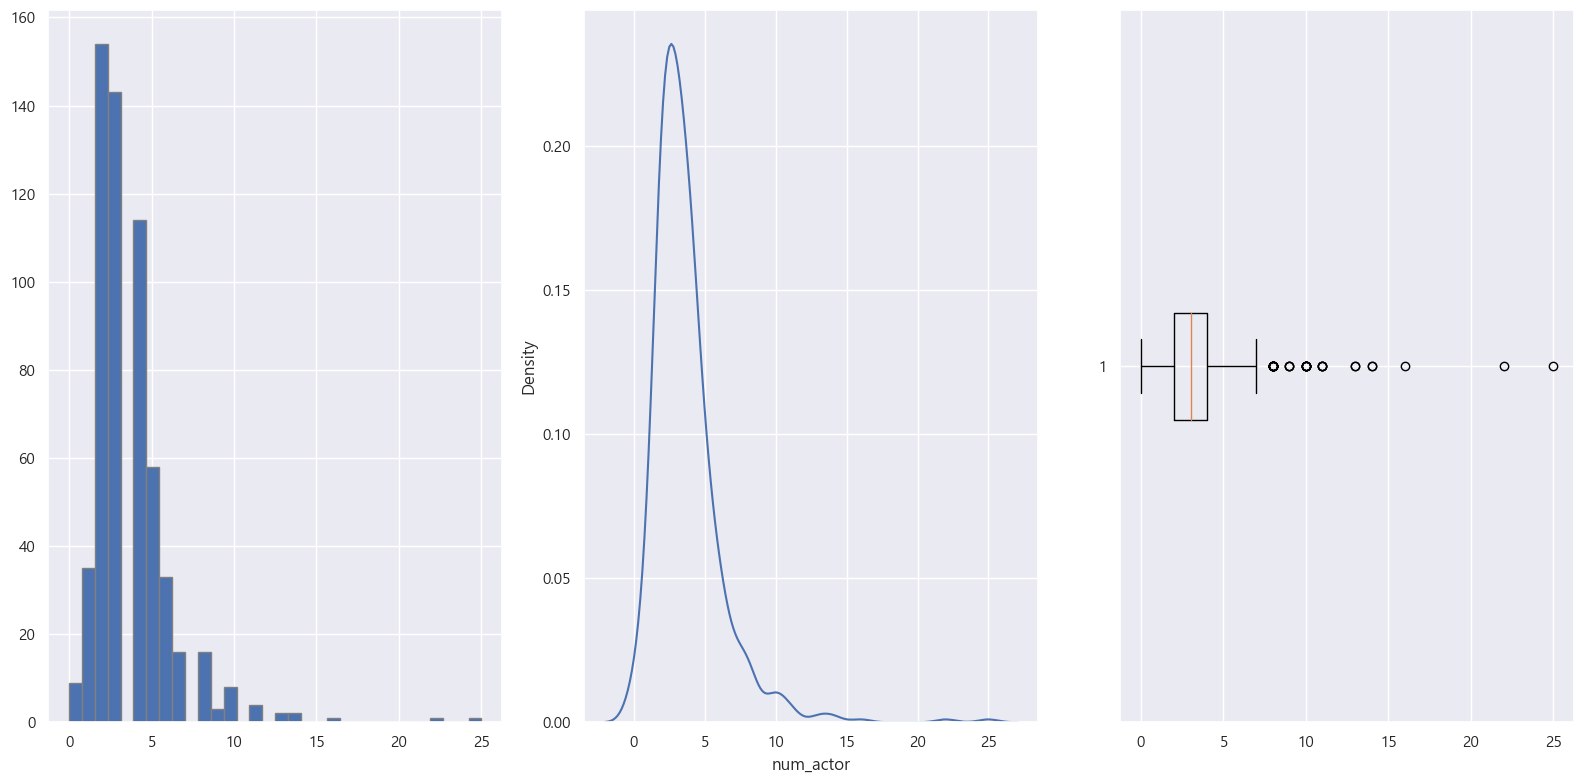

smaller :  [2. 0.]
bigger :  [4. 7.]
count    600.000000
mean       3.706667
std        2.446889
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       25.000000
Name: num_actor, dtype: float64


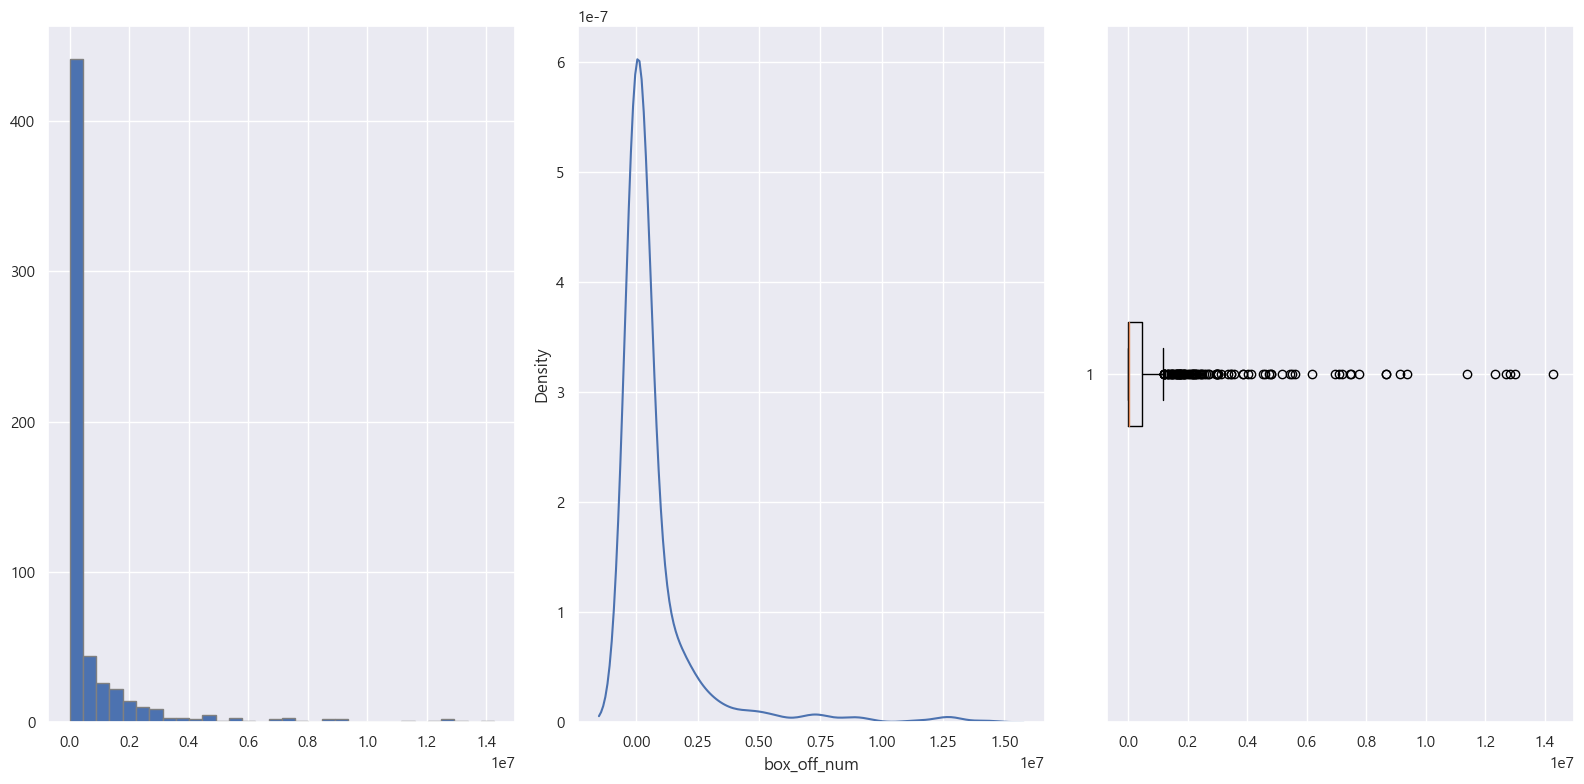

smaller :  [1.29725e+03 1.00000e+00]
bigger :  [ 479886.75 1177435.  ]
count    6.000000e+02
mean     7.081818e+05
std      1.828006e+06
min      1.000000e+00
25%      1.297250e+03
50%      1.259100e+04
75%      4.798868e+05
max      1.426277e+07
Name: box_off_num, dtype: float64
0    0.663333
1    0.336667
Name: screening_rat_15세 관람가, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


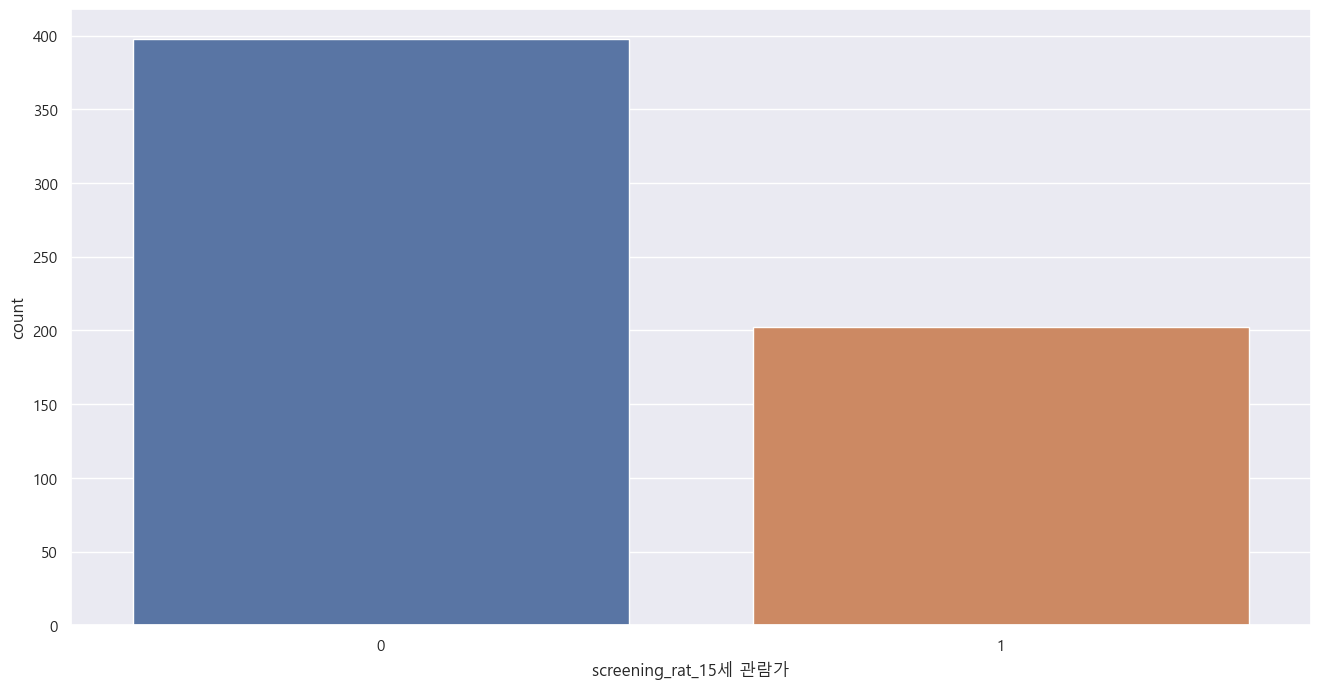

0    0.846667
1    0.153333
Name: screening_rat_전체 관람가, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


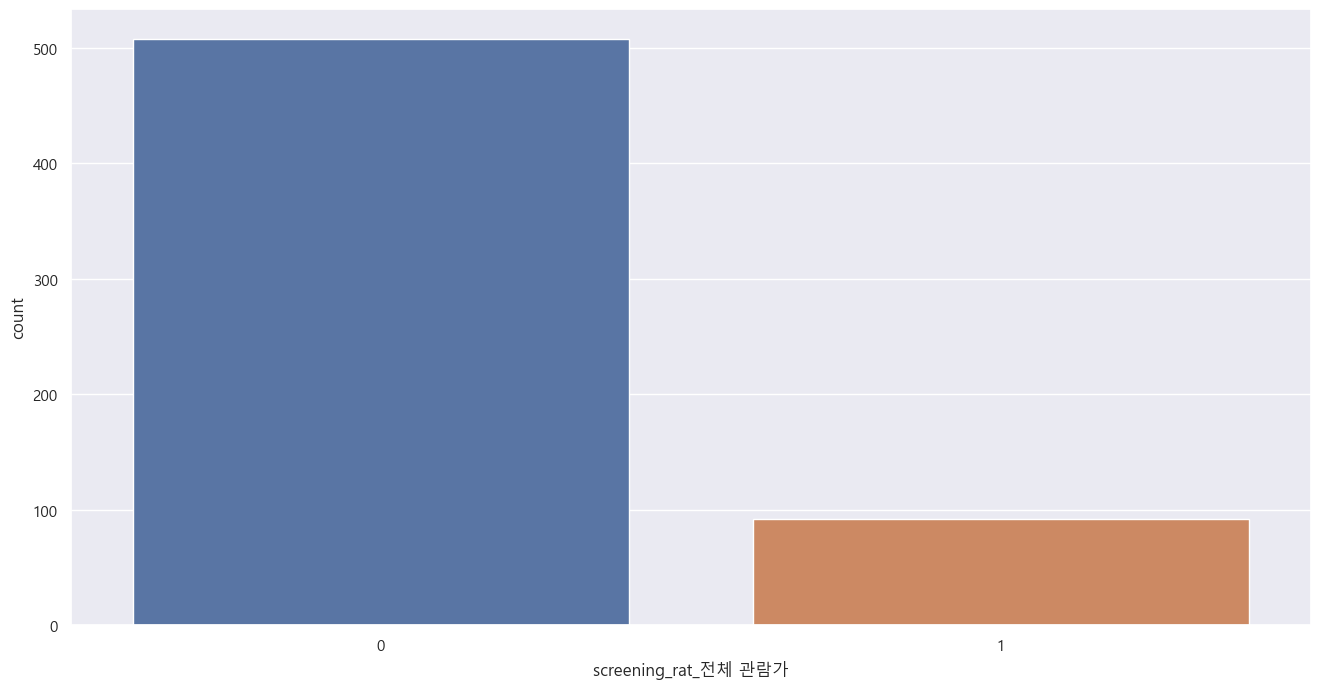

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    0.66
1    0.34
Name: screening_rat_청소년 관람불가, dtype: float64


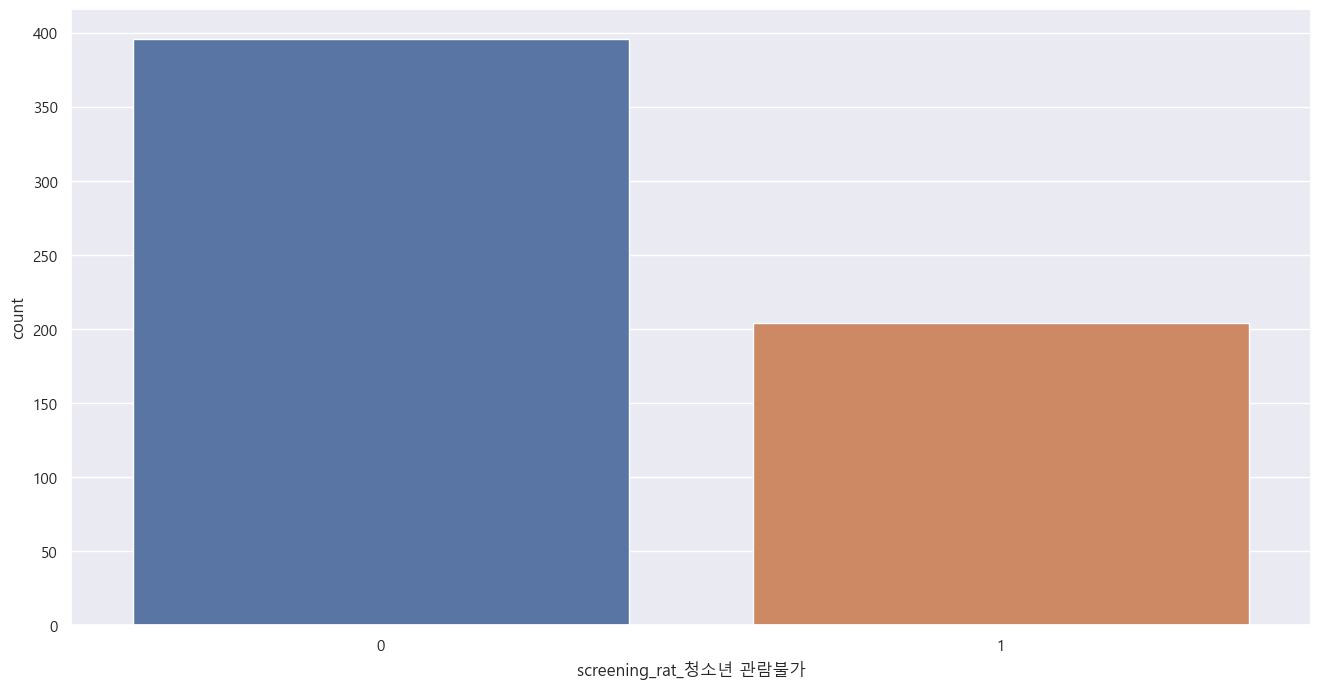

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    0.93
1    0.07
Name: genre_공포, dtype: float64


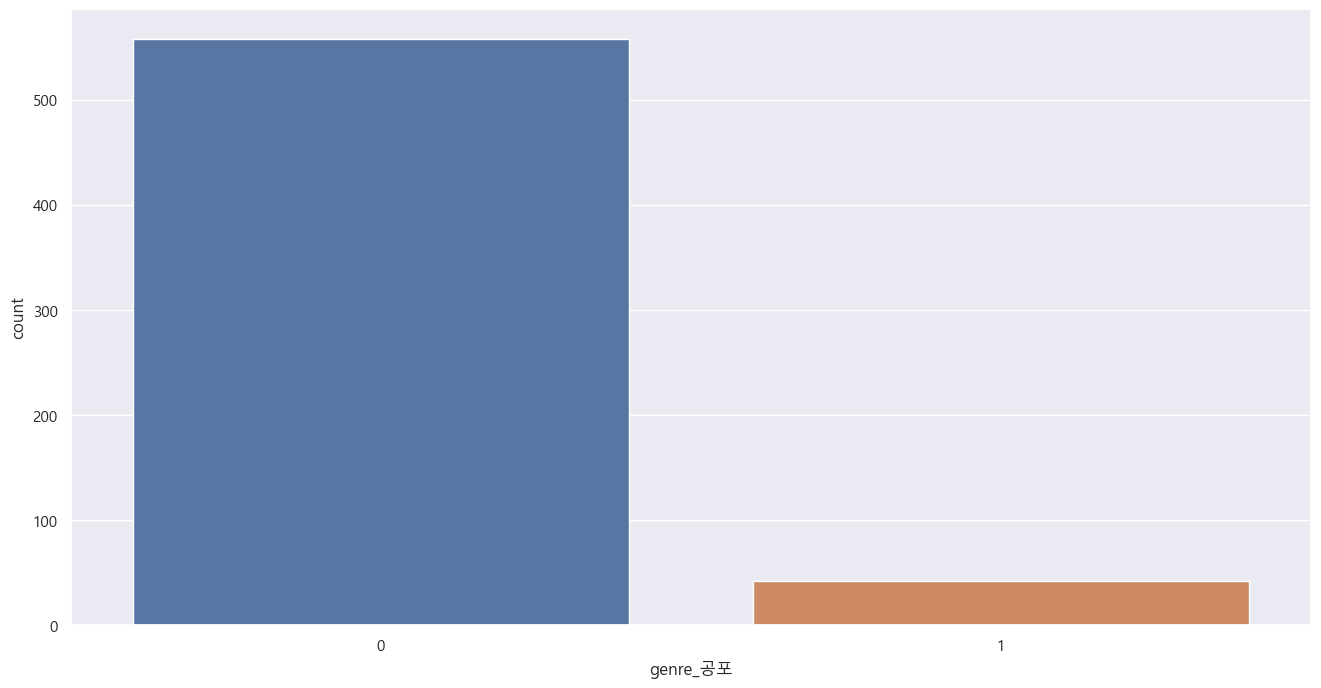

0    0.955
1    0.045
Name: genre_느와르, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


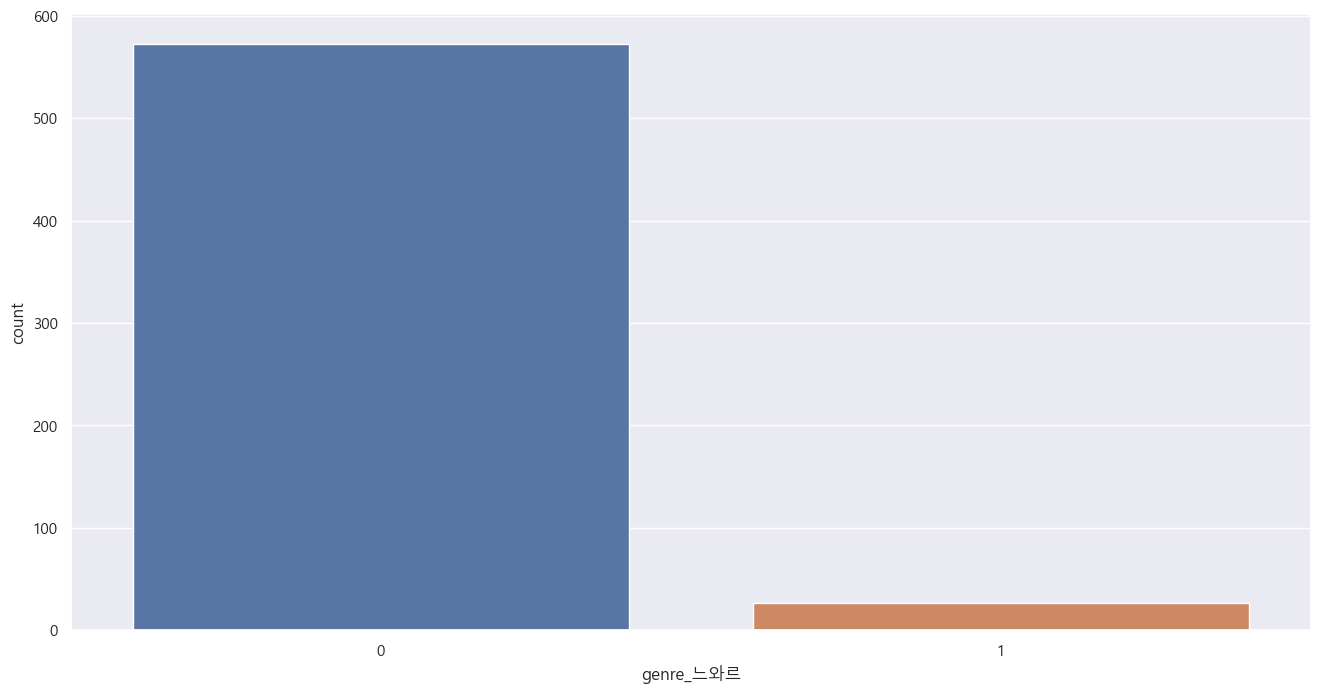

0    0.845
1    0.155
Name: genre_다큐멘터리, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


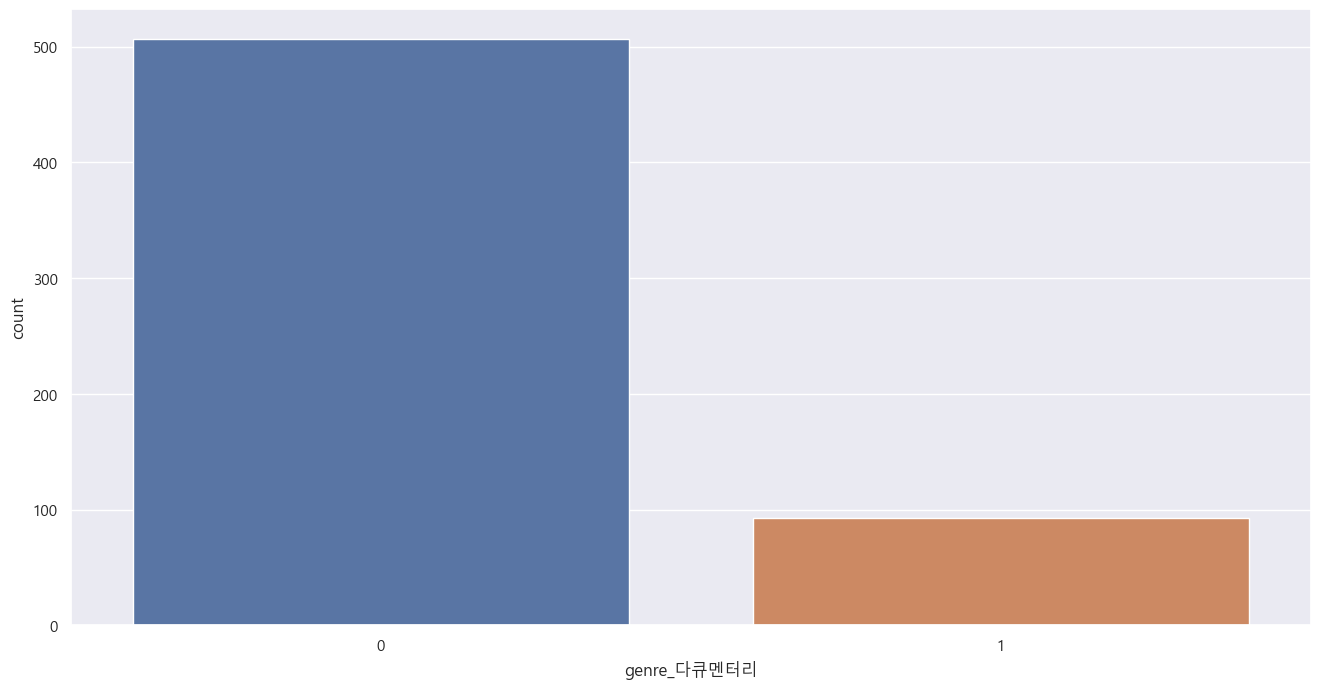

0    0.631667
1    0.368333
Name: genre_드라마, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


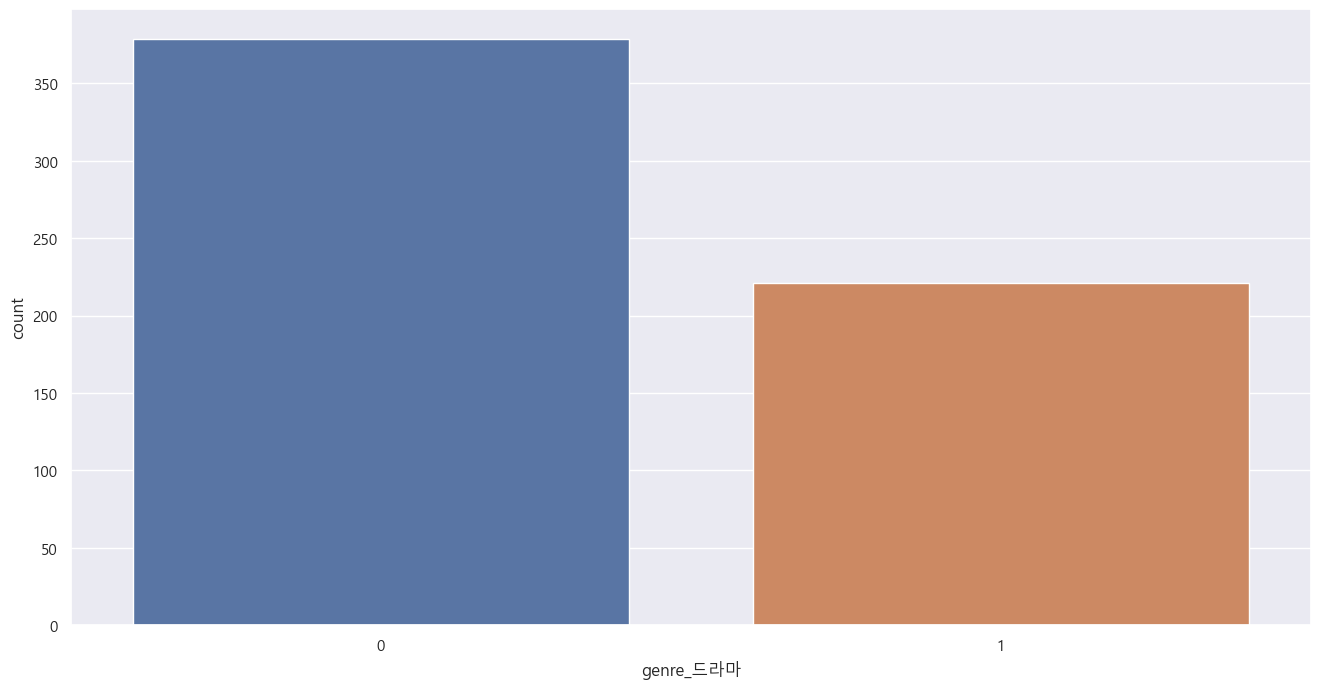

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    0.87
1    0.13
Name: genre_멜로/로맨스, dtype: float64


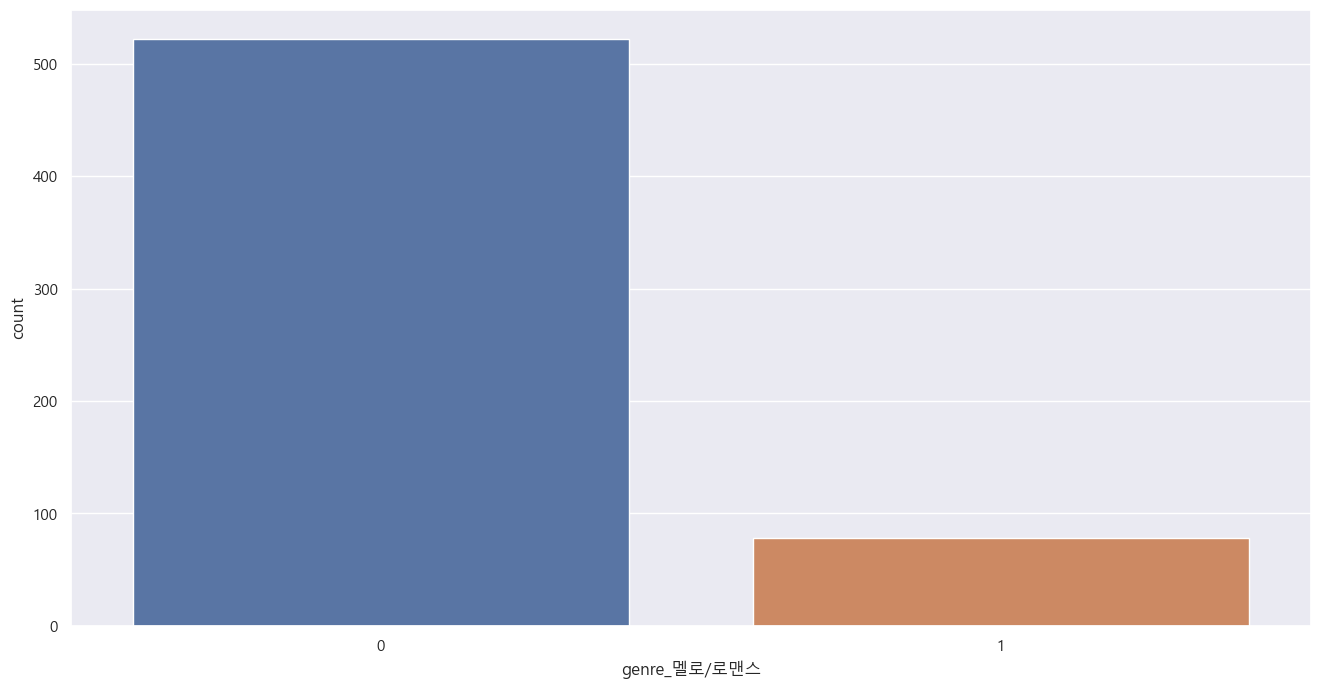

0    0.991667
1    0.008333
Name: genre_뮤지컬, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


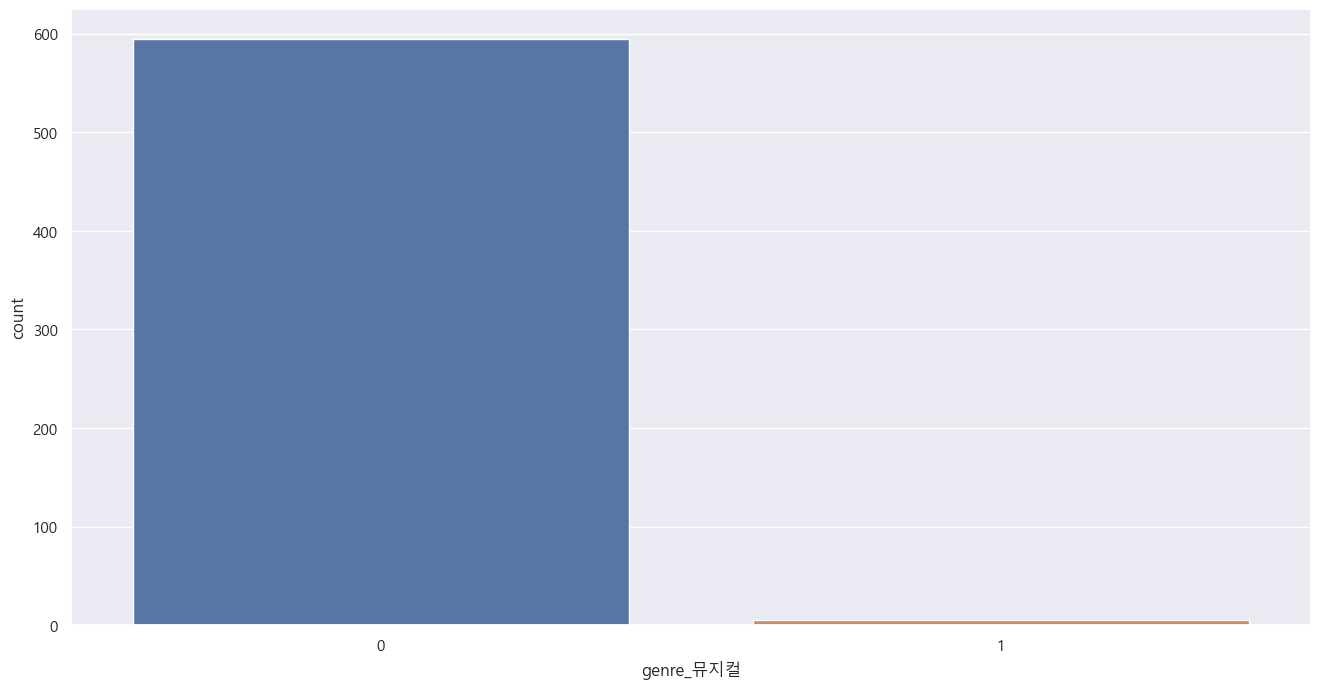

0    0.971667
1    0.028333
Name: genre_미스터리, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


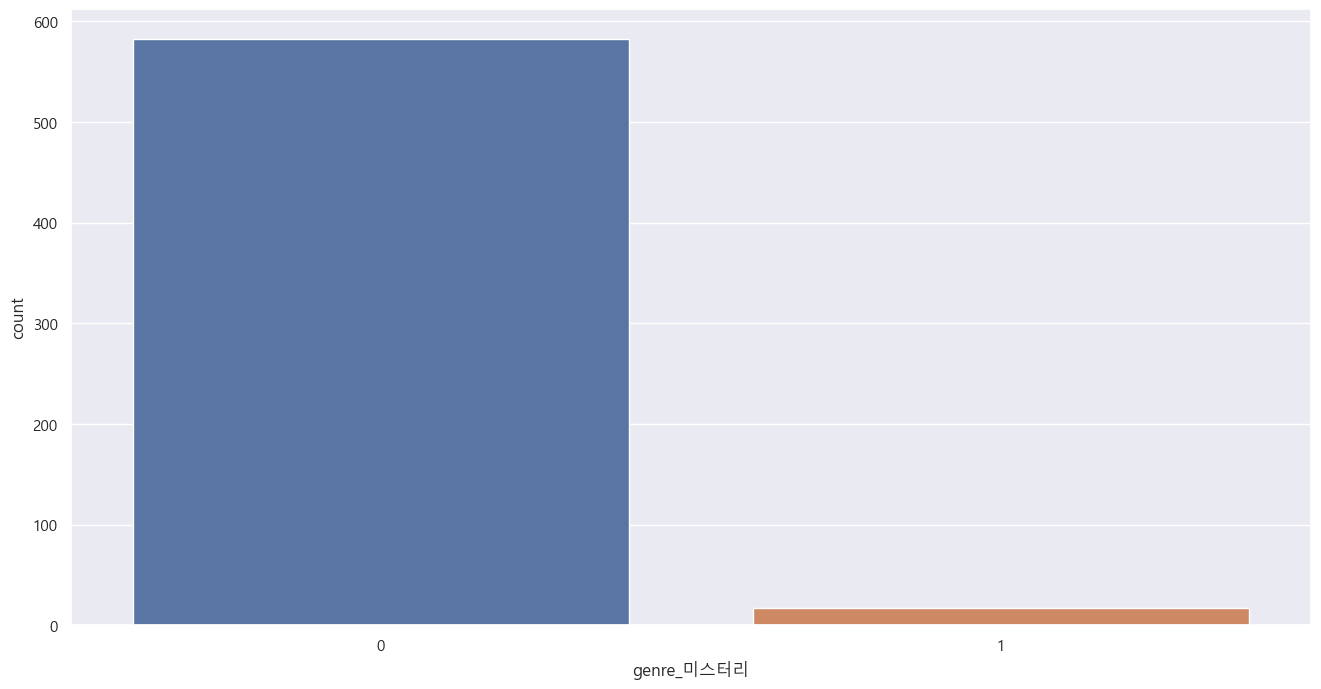

0    0.996667
1    0.003333
Name: genre_서스펜스, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


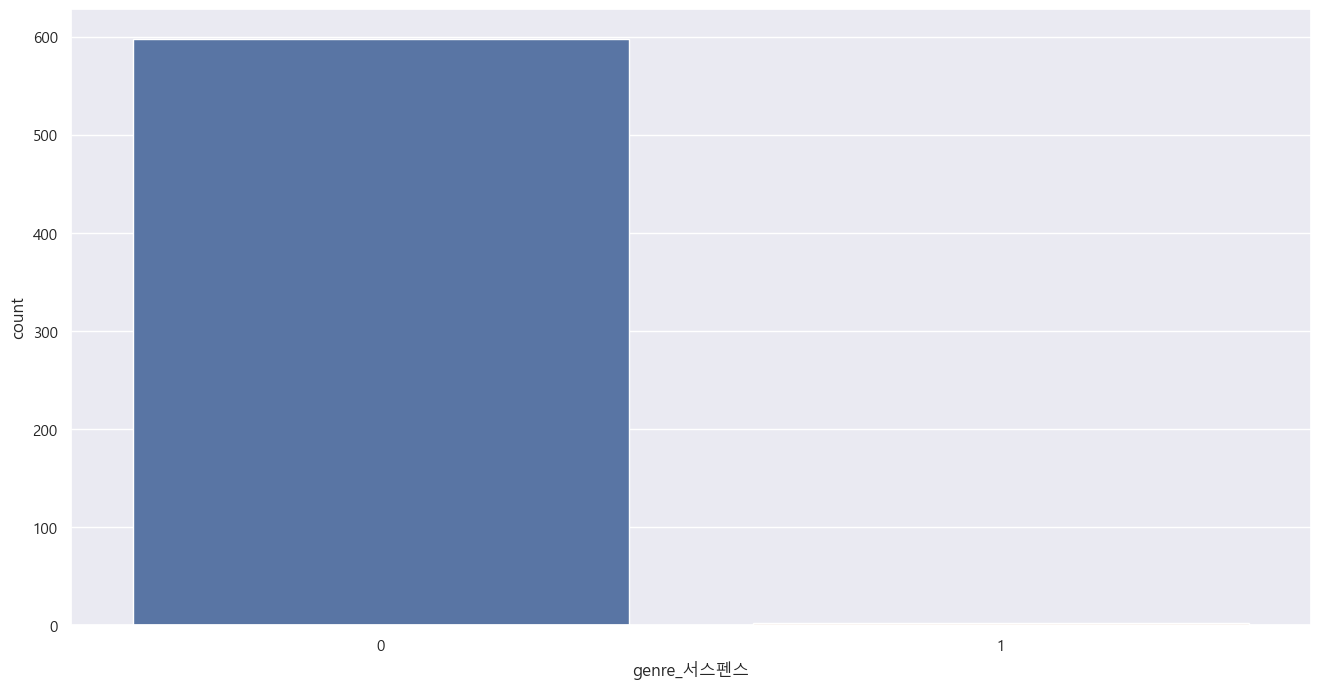

0    0.965
1    0.035
Name: genre_애니메이션, dtype: float64


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


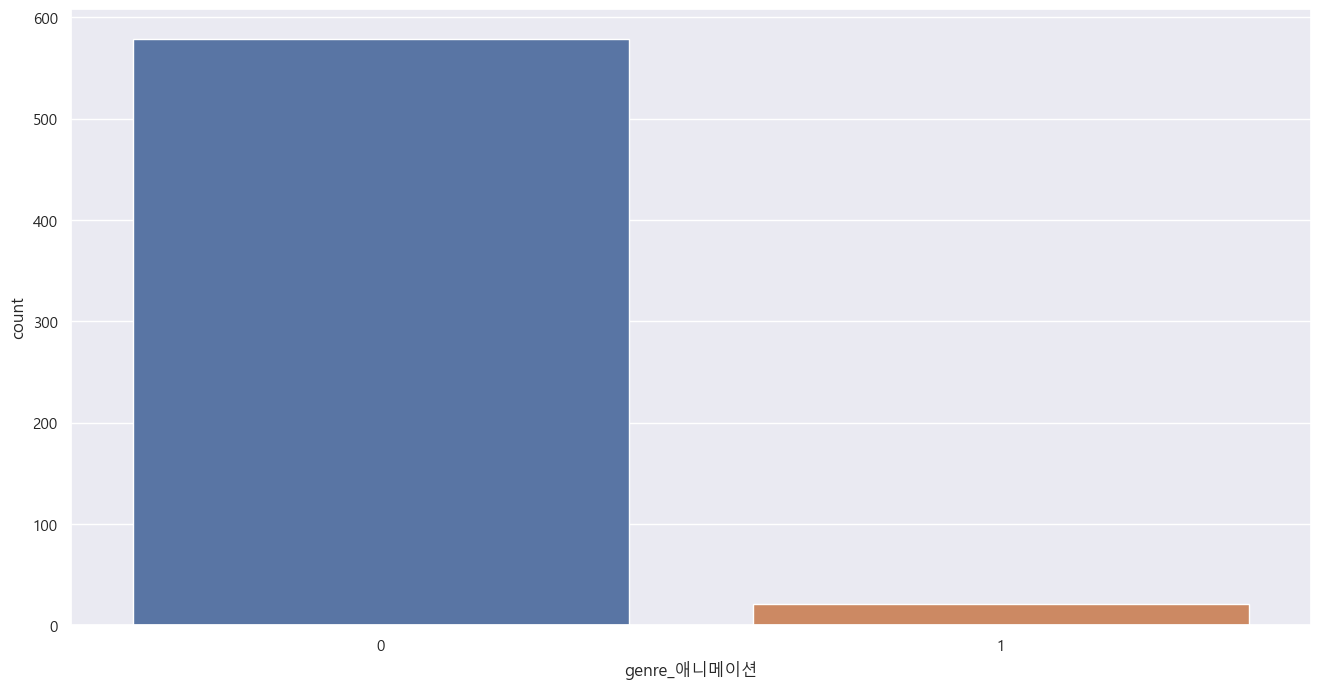

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    0.953333
1    0.046667
Name: genre_액션, dtype: float64


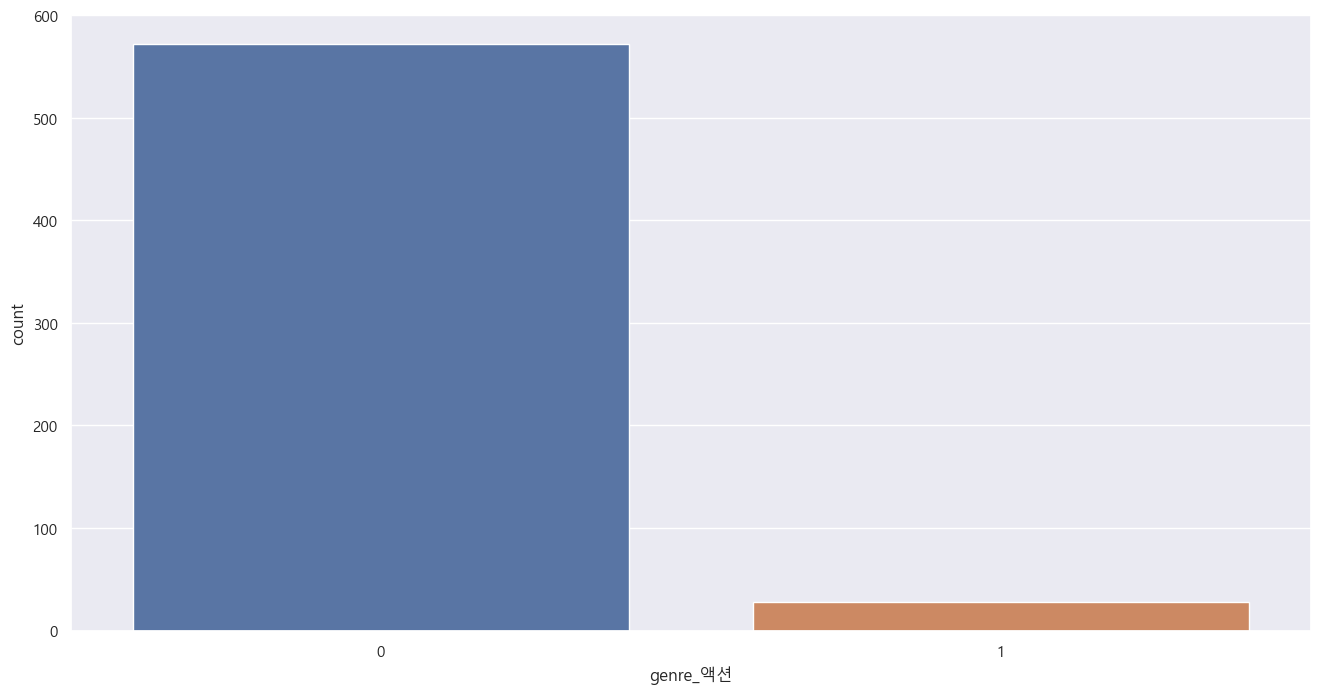

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0    0.911667
1    0.088333
Name: genre_코미디, dtype: float64


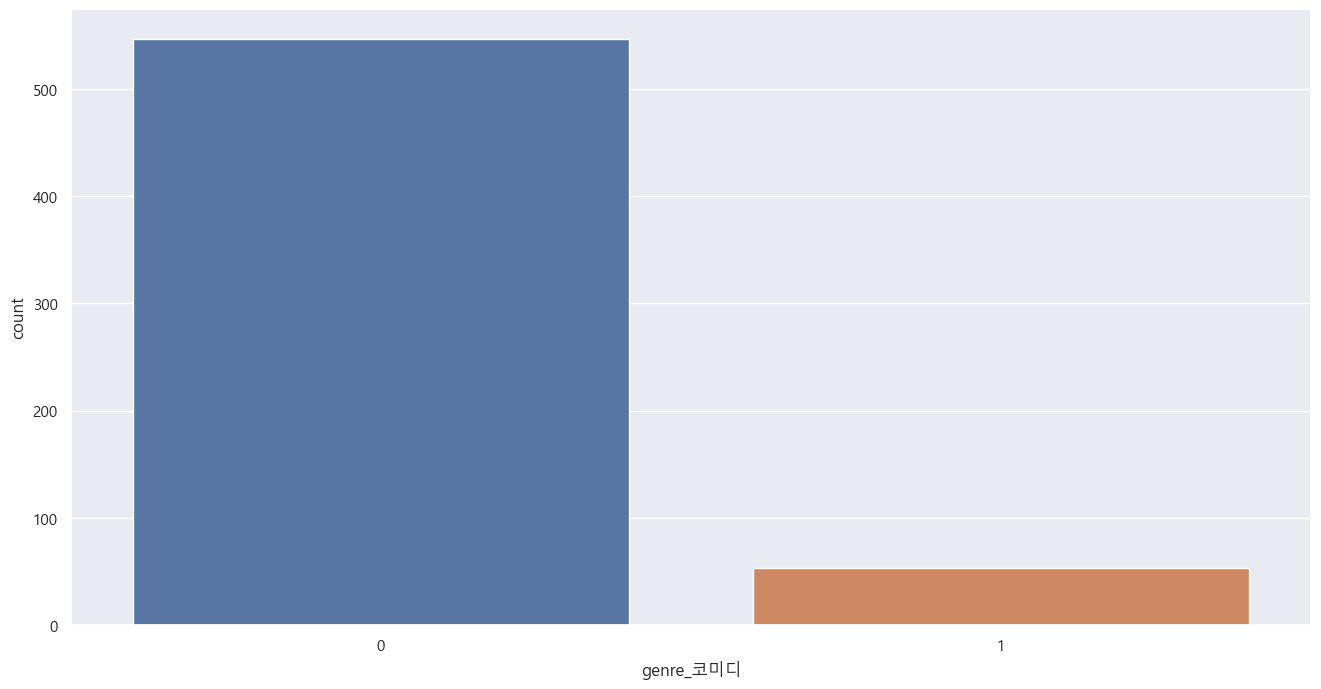

In [67]:
cat_lst = ['screening_rat','genre']

for col in data.columns:
    
    if col == 'release_time' : continue
    flag = True
    plt.figure(figsize=(16,8))
    for cat in cat_lst:
        if cat in col:
            da.Unvariate(data,col,'cat')
            flag = False
            break
        
    if flag:
        da.Unvariate(data,col,'num')
        
    
        

## 이변량 분석

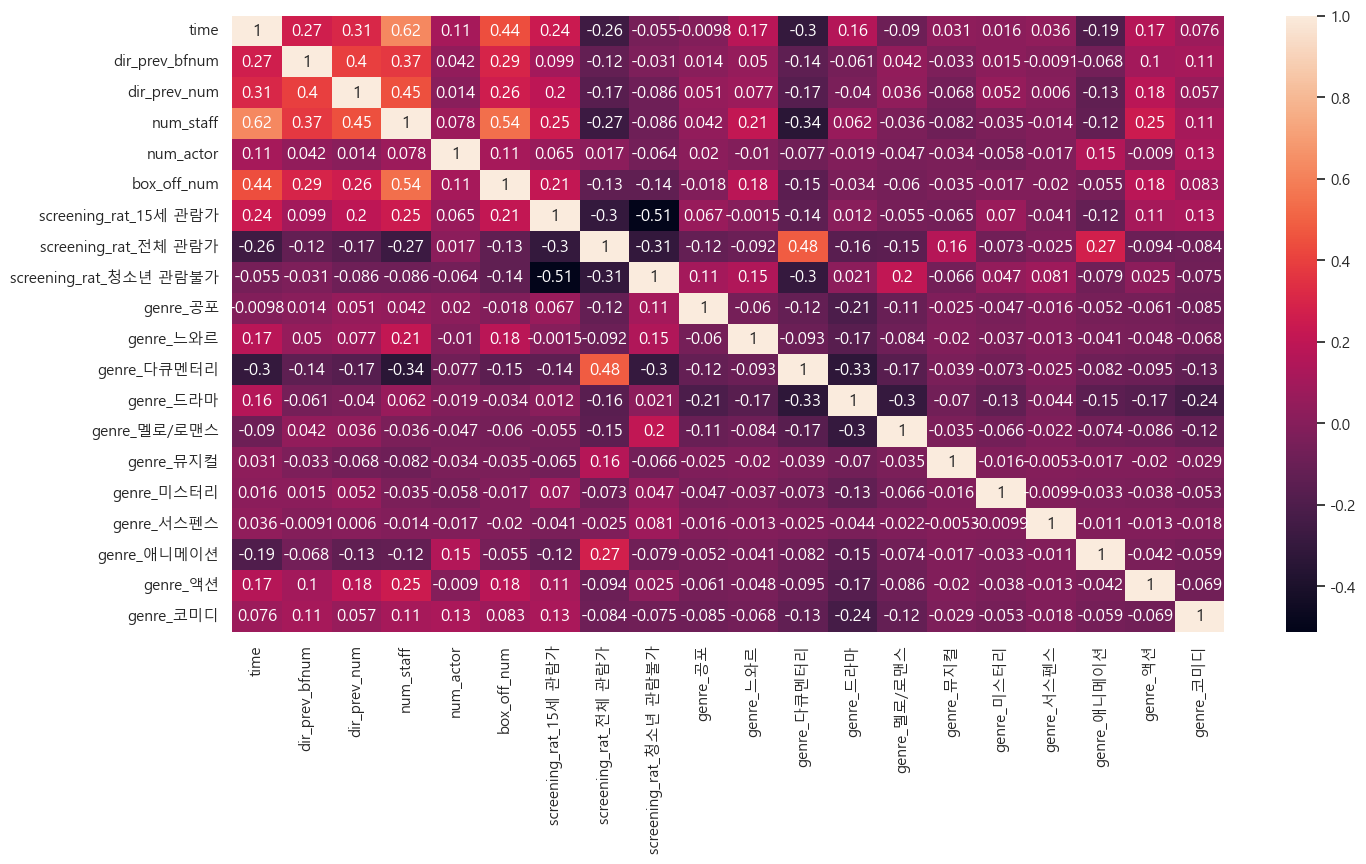

In [68]:
plt.figure(figsize=(16,8))

sns.heatmap(data.corr(),annot = True)
plt.show()

# 데이터 나누기

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x = data.drop(['box_off_num','release_time'],axis=1)
y = data['box_off_num']

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.3,)

# 모델링

In [18]:
import Util_for_sklearn_ksw as ufs
from sklearn.inspection import permutation_importance

## LinearRegression

In [19]:
lst,df = ufs.forward_stepwise_linear(x_train,y_train)
print(lst)

['num_staff', 'time', 'dir_prev_bfnum', 'screening_rat_청소년 관람불가', 'genre_느와르', 'genre_액션', 'num_actor']


In [20]:
model_line = LinearRegression()
model_line.fit(x_train[lst],y_train)
pred_line = model_line.predict(x_val[lst])


In [21]:
ufs.Regressor_report(y_val,pred_line)

MAE :  790809.0479880068
MAPE :  4156.515194607116
RMSE :  1460867.5234219232


## KNN

### 스케일링

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [23]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### CV

In [24]:
model_knn = KNeighborsRegressor()

params_knn = {'n_neighbors':range(5,15),'metric':['manhattan','euclidean']}

model_knn_g = GridSearchCV(model_knn,params_knn,cv=10,verbose=3)


In [25]:
model_knn_g.fit(x_train_s,y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10] END ..metric=manhattan, n_neighbors=5;, score=0.304 total time=   0.0s
[CV 2/10] END ..metric=manhattan, n_neighbors=5;, score=0.003 total time=   0.0s
[CV 3/10] END ..metric=manhattan, n_neighbors=5;, score=0.348 total time=   0.0s
[CV 4/10] END .metric=manhattan, n_neighbors=5;, score=-0.014 total time=   0.0s
[CV 5/10] END ..metric=manhattan, n_neighbors=5;, score=0.187 total time=   0.0s
[CV 6/10] END .metric=manhattan, n_neighbors=5;, score=-0.556 total time=   0.0s
[CV 7/10] END ..metric=manhattan, n_neighbors=5;, score=0.058 total time=   0.0s
[CV 8/10] END ..metric=manhattan, n_neighbors=5;, score=0.052 total time=   0.0s
[CV 9/10] END .metric=manhattan, n_neighbors=5;, score=-0.354 total time=   0.0s
[CV 10/10] END .metric=manhattan, n_neighbors=5;, score=0.200 total time=   0.0s
[CV 1/10] END ..metric=manhattan, n_neighbors=6;, score=0.282 total time=   0.0s
[CV 2/10] END ..metric=manhattan, n_neighbors=

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['manhattan', 'euclidean'],
                         'n_neighbors': range(5, 15)},
             verbose=3)

### Feature Importance 확인

In [26]:
pfi_knn = permutation_importance(model_knn_g.best_estimator_, x_val_s, y_val, n_repeats=10, scoring = 'r2')

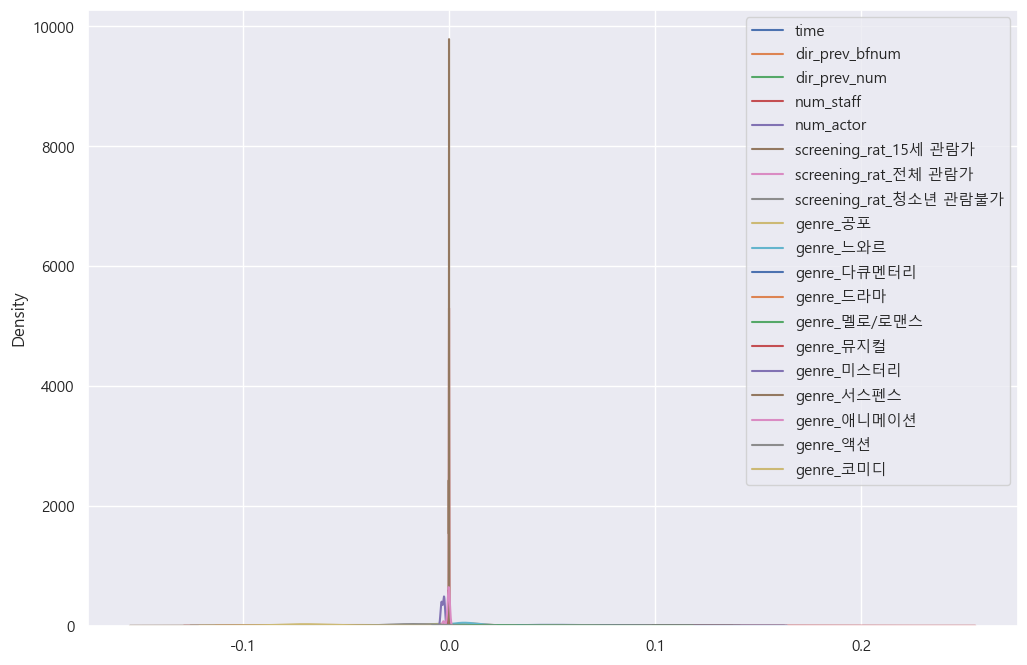

In [27]:
plt.figure(figsize = (12,8))
for i,vars in enumerate(list(x)) :
    sns.kdeplot(pfi_knn.importances[i], label = vars)

plt.legend()
plt.show()

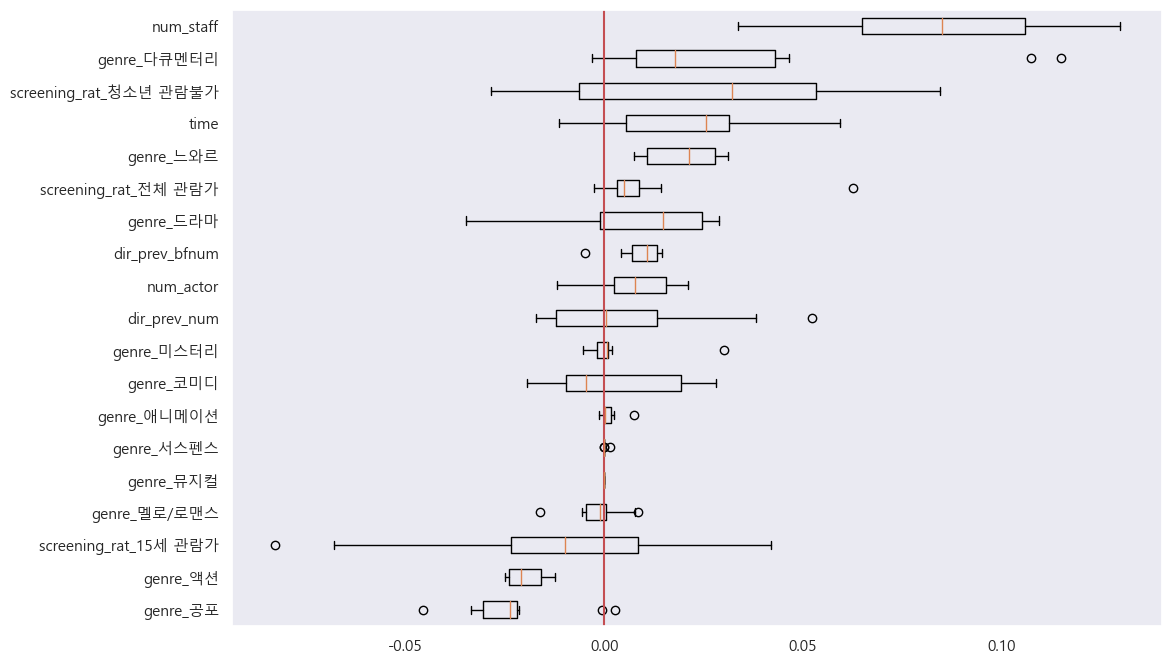

In [105]:
sorted_idx = pfi_knn.importances_mean.argsort()
plt.figure(figsize = (12,8))
plt.boxplot(pfi_knn.importances[sorted_idx].T, vert=False, labels=x.columns[sorted_idx])
plt.axvline(0, color = 'r')
plt.grid()
plt.show()

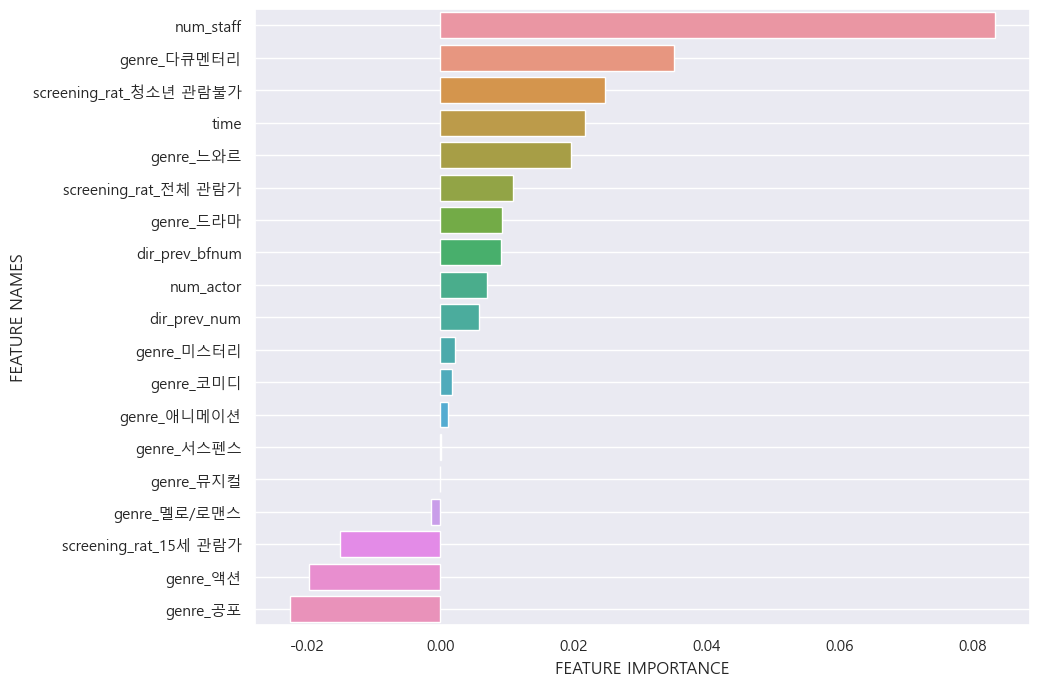

In [106]:
result = ufs.plot_feature_importance(pfi_knn.importances_mean, list(x_train))

In [28]:
pred_knn = model_knn_g.predict(x_val_s)

ufs.Regressor_report(y_val,pred_knn)

MAE :  635159.7523809524
MAPE :  248.030289500673
RMSE :  1488486.0413034428


## RandomForest

In [29]:
model_rf = RandomForestRegressor()

params_rf = {'n_estimators':range(50,100,10),'max_depth':range(5,10),'min_samples_leaf':range(30,100,10)}

model_rf_g = GridSearchCV(model_rf,params_rf,cv=10,verbose=3)

In [30]:
model_rf_g.fit(x_train,y_train)

Fitting 10 folds for each of 175 candidates, totalling 1750 fits
[CV 1/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=0.323 total time=   0.0s
[CV 2/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=0.351 total time=   0.0s
[CV 3/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=0.276 total time=   0.0s
[CV 4/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=0.322 total time=   0.0s
[CV 5/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=0.387 total time=   0.0s
[CV 6/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=0.280 total time=   0.0s
[CV 7/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=0.311 total time=   0.0s
[CV 8/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=0.236 total time=   0.0s
[CV 9/10] END max_depth=5, min_samples_leaf=30, n_estimators=50;, score=-0.449 total time=   0.0s
[CV 10/10] END max_depth=5, min_samples_leaf=30, n_estimators

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(5, 10),
                         'min_samples_leaf': range(30, 100, 10),
                         'n_estimators': range(50, 100, 10)},
             verbose=3)

In [31]:
model_rf_g.best_params_

{'max_depth': 9, 'min_samples_leaf': 30, 'n_estimators': 50}

In [32]:
cv_rf = pd.DataFrame(model_rf_g.cv_results_)
cv_rf.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.069768      0.012681         0.006752        0.002868   
1       0.079564      0.002861         0.005705        0.000813   
2       0.095504      0.009249         0.007332        0.001132   
3       0.129402      0.028195         0.009261        0.002592   
4       0.171971      0.039814         0.015394        0.009118   

  param_max_depth param_min_samples_leaf param_n_estimators  \
0               5                     30                 50   
1               5                     30                 60   
2               5                     30                 70   
3               5                     30                 80   
4               5                     30                 90   

                                              params  split0_test_score  \
0  {'max_depth': 5, 'min_samples_leaf': 30, 'n_es...           0.323386   
1  {'max_depth': 5, 'min_samples_leaf': 30, 'n_es...           0.331496   
2  {'max_depth': 5, 'min_samples_leaf': 30, 'n_es...           0.330145   
3  {'max_depth': 5, 'min_samples_leaf': 30, 'n_es...           0.328167   
4  {'max_depth': 5, 'min_samples_leaf': 30, 'n_es...           0.318408   

   split1_test_score  ...  split3_test_score  split4_test_score  \
0           0.350812  ...           0.321874           0.387137   
1           0.349370  ...           0.321005           0.375052   
2           0.360326  ...           0.324837           0.371112   
3           0.337976  ...           0.333059           0.368399   
4           0.358467  ...           0.321087           0.366836   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
0           0.280003           0.311492           0.236071          -0.448556   
1           0.321674           0.317008           0.197324          -0.207156   
2           0.328034           0.307965           0.189758          -0.378127   
3           0.338297           0.310893           0.180636          -0.344020   
4           0.268524           0.289974           0.193447          -0.278151   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.336644         0.237532        0.232170               23  
1           0.331564         0.260577        0.162623                2  
2           0.302494         0.243677        0.212453               18  
3           0.326066         0.247185        0.202841               13  
4           0.332138         0.243883        0.180536               17  

[5 rows x 21 columns]

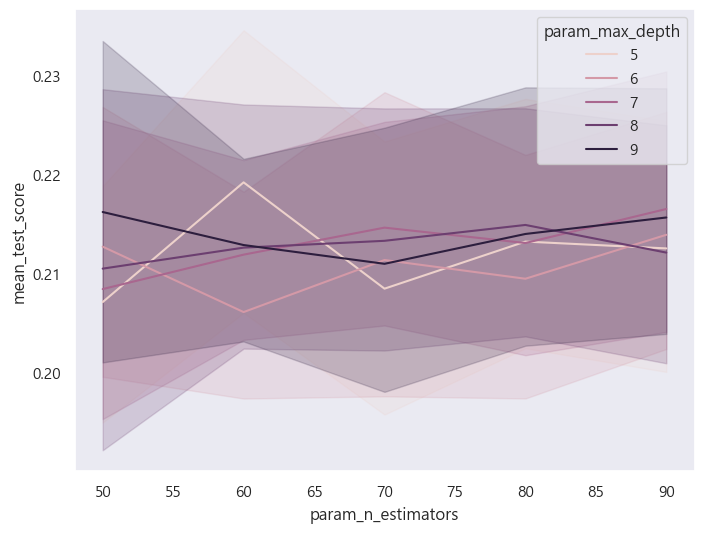

In [33]:
ufs.mean_test_score_lineplot(cv_rf,x='param_n_estimators',hue='param_max_depth')

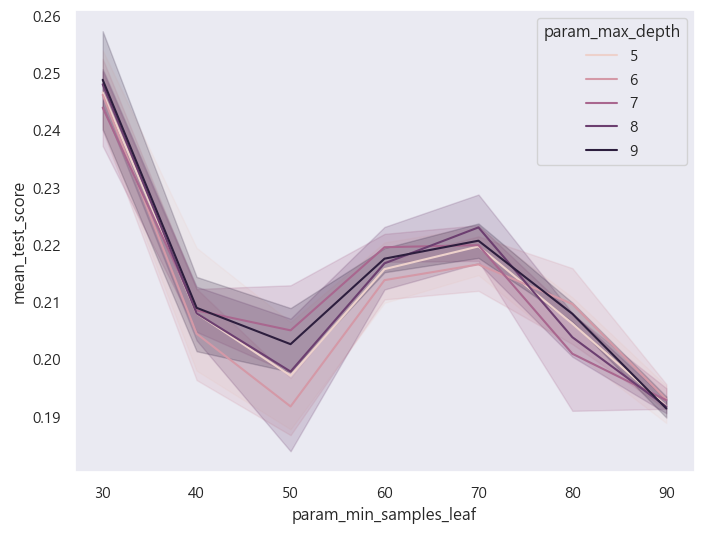

In [34]:
ufs.mean_test_score_lineplot(cv_rf,x='param_min_samples_leaf',hue='param_max_depth')

feature_names  feature_importance
0                num_staff            0.652680
1                     time            0.343649
2    screening_rat_15세 관람가            0.002001
3           dir_prev_bfnum            0.001219
4     screening_rat_전체 관람가            0.000286
5                num_actor            0.000106
6   screening_rat_청소년 관람불가            0.000051
7                genre_드라마            0.000007
8                genre_뮤지컬            0.000000
9                 genre_액션            0.000000
10             genre_애니메이션            0.000000
11              genre_서스펜스            0.000000
12              genre_미스터리            0.000000
13               genre_느와르            0.000000
14            genre_멜로/로맨스            0.000000
15             genre_다큐멘터리            0.000000
16                genre_공포            0.000000
17            dir_prev_num            0.000000
18               genre_코미디            0.000000

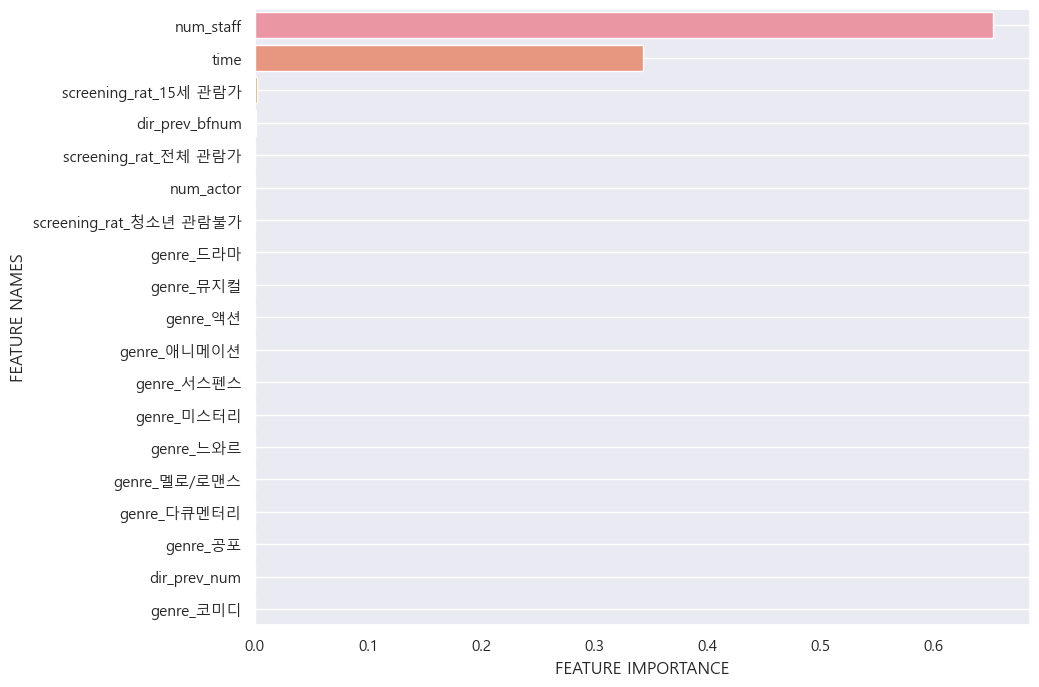

In [35]:
ufs.plot_feature_importance(model_rf_g.best_estimator_.feature_importances_,list(x_train))

In [36]:
pred_rf = model_rf_g.predict(x_val)

ufs.Regressor_report(y_val,pred_rf)

MAE :  607392.3060592778
MAPE :  221.20174868172228
RMSE :  1385576.7960274073


## CatBoost

In [39]:
model_cbt = cbt.CatBoostRegressor()

params_cbt =    {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10 ,30,50,70, 100]
                 }

model_cbt_g = GridSearchCV(model_cbt,params_cbt,cv=10,verbose=3)

In [40]:
model_cbt_g.fit(x_train,y_train)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits
0:	learn: 1896433.5313811	total: 157ms	remaining: 1.42s
1:	learn: 1889312.3428798	total: 158ms	remaining: 633ms
2:	learn: 1881795.1181723	total: 159ms	remaining: 371ms
3:	learn: 1874001.9855197	total: 160ms	remaining: 239ms
4:	learn: 1867073.6074568	total: 160ms	remaining: 160ms
5:	learn: 1860061.6242876	total: 161ms	remaining: 107ms
6:	learn: 1853840.1037219	total: 162ms	remaining: 69.3ms
7:	learn: 1848889.0000844	total: 162ms	remaining: 40.6ms
8:	learn: 1842999.5426766	total: 163ms	remaining: 18.1ms
9:	learn: 1836176.8679831	total: 164ms	remaining: 0us
[CV 1/10] END depth=4, iterations=10, learning_rate=0.01;, score=0.055 total time=   0.1s
0:	learn: 1811365.3759738	total: 815us	remaining: 7.33ms
1:	learn: 1804581.3966238	total: 1.47ms	remaining: 5.88ms
2:	learn: 1797529.2468193	total: 2.14ms	remaining: 5ms
3:	learn: 1791096.9864711	total: 2.82ms	remaining: 4.23ms
4:	learn: 1784022.0837228	total: 3.44ms	remaining: 3.44m

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000163BC060490>,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 30, 50, 70, 100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]},
             verbose=3)

In [43]:
pd_cbt = pd.DataFrame(model_cbt_g.cv_results_)
pd_cbt

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_depth  \
0         0.051499      0.064091         0.002963        0.000867           4   
1         0.028485      0.001843         0.002859        0.000650           4   
2         0.048947      0.011233         0.004820        0.002257           4   
3         0.055392      0.017765         0.005877        0.004566           4   
4         0.044365      0.003569         0.002842        0.000828           4   
..             ...           ...              ...             ...         ...   
135       1.584270      0.244434         0.004486        0.001675          10   
136       2.379960      0.357670         0.004707        0.001254          10   
137       2.233026      0.339460         0.004320        0.001822          10   
138       2.527249      0.172409         0.006436        0.002012          10   
139       2.472169      0.370722         0.008139        0.010539          10   

    param_iterations param_learning_rate  \
0                 10                0.01   
1                 10                0.02   
2                 10                0.03   
3                 10                0.04   
4                 30                0.01   
..               ...                 ...   
135               70                0.04   
136              100                0.01   
137              100                0.02   
138              100                0.03   
139              100                0.04   

                                                params  split0_test_score  \
0    {'depth': 4, 'iterations': 10, 'learning_rate'...           0.055440   
1    {'depth': 4, 'iterations': 10, 'learning_rate'...           0.108614   
2    {'depth': 4, 'iterations': 10, 'learning_rate'...           0.132290   
3    {'depth': 4, 'iterations': 10, 'learning_rate'...           0.156699   
4    {'depth': 4, 'iterations': 30, 'learning_rate'...           0.142444   
..                                                 ...                ...   
135  {'depth': 10, 'iterations': 70, 'learning_rate...           0.210620   
136  {'depth': 10, 'iterations': 100, 'learning_rat...           0.183664   
137  {'depth': 10, 'iterations': 100, 'learning_rat...           0.263131   
138  {'depth': 10, 'iterations': 100, 'learning_rat...           0.251214   
139  {'depth': 10, 'iterations': 100, 'learning_rat...           0.231389   

     split1_test_score  ...  split3_test_score  split4_test_score  \
0             0.016580  ...           0.036854           0.046948   
1             0.050328  ...           0.095276           0.098180   
2             0.073641  ...           0.131177           0.149540   
3             0.101183  ...           0.132797           0.182468   
4             0.083041  ...           0.136960           0.134748   
..                 ...  ...                ...                ...   
135           0.197942  ...           0.198659           0.358981   
136           0.120771  ...           0.168154           0.184503   
137           0.164463  ...           0.253461           0.260615   
138           0.177208  ...           0.205463           0.308606   
139           0.201898  ...           0.158328           0.369428   

     split5_test_score  split6_test_score  split7_test_score  \
0             0.021713           0.051998           0.061620   
1             0.115413           0.105200           0.111446   
2             0.137789           0.149148           0.165513   
3             0.229460           0.179315           0.208683   
4             0.197668           0.135182           0.168023   
..                 ...                ...                ...   
135           0.549370           0.356889           0.425395   
136           0.382981           0.240328           0.285110   
137           0.454090           0.345883           0.374203   
138           0.555444           0.321892           0.438252   
139           0.560015           0.385507    

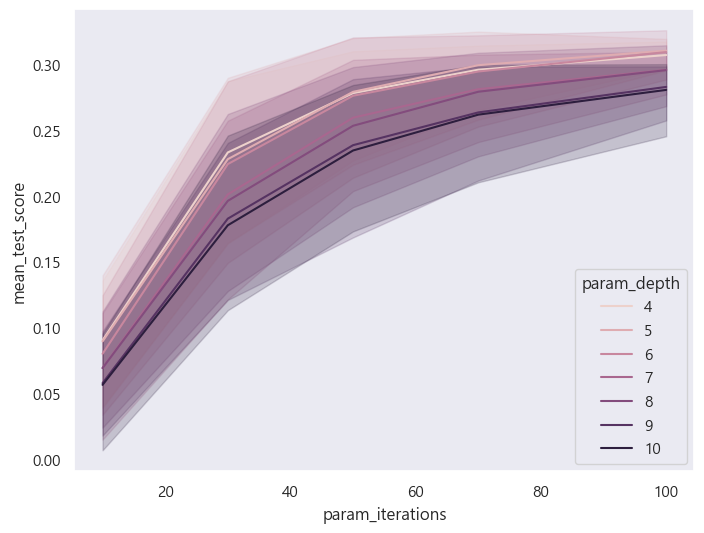

In [44]:
ufs.mean_test_score_lineplot(pd_cbt,x='param_iterations',hue='param_depth')

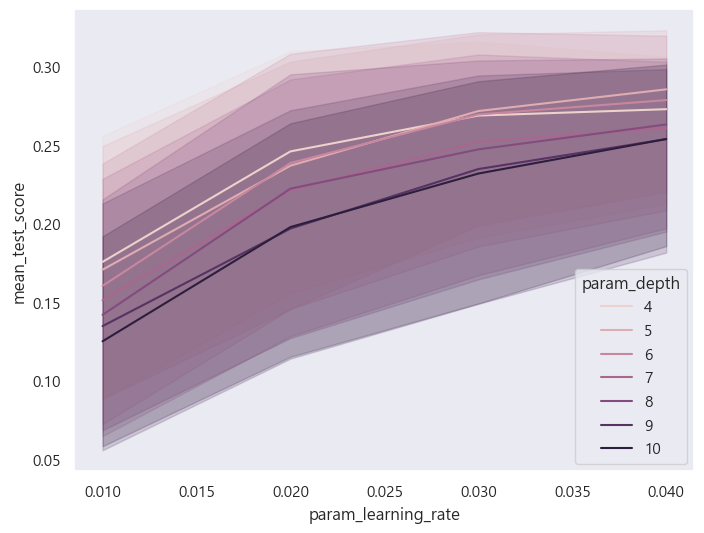

In [45]:
ufs.mean_test_score_lineplot(pd_cbt,x='param_learning_rate',hue='param_depth')

In [42]:
model_cbt_g.best_params_

{'depth': 6, 'iterations': 100, 'learning_rate': 0.03}

In [41]:
pred_cbt = model_cbt_g.predict(x_val)

ufs.Regressor_report(y_val,pred_cbt)

MAE :  581980.9069252164
MAPE :  764.6163270401927
RMSE :  1311423.4878043467
